In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import re
import HMM_soln as HMM
import HMM_helper as HMM_helper

import os
from IPython.display import HTML

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

In [4]:
#preprocess each word
def parse_word(word):
    word = word.lower()
    #delete puncuations
    if word.endswith(','): 
        word = word[:-1]
    if word.endswith('.'):
        word = word[:-1]
    if word.endswith('?'): 
        word = word[:-1]
    if word.endswith('!'): 
        word = word[:-1]
    if word.endswith('?'): 
        word = word[:-1]
    if word.endswith(';'): 
        word = word[:-1]
    if word.endswith(':'): 
        word = word[:-1]
    if word.endswith(')'): 
        word = word[:-1]
    if word.endswith("'"):
        if word != "th'":
            word = word[:-1]
    if word.startswith('('):
        word = word[1:]
    if word.startswith("'"):
        word = word[1:]
    return word

#return each poem as a list of words in list
def get_per_poem(filename):    
    poem_list = []
    with open(filename) as f:
        poem = ''
        poem_index = 0
        for line in f:
            if line.split() == []:
                continue
                
            if line.split()[0].isdigit():
                poem_index = int(line.split()[0])
                #print(poem_index)
                if poem_index != 1:
                    #get rid of new line
                    poem=re.sub("\n"," ",poem)
                    #lowercase
                    poem = poem.lower()

                    #append the previous poem to list
                    poem_list.append(poem.split())
                    #start the next poem witg empty string
                    poem = ''  
                continue
                
            #add the words in the poem
            for word in line.split():
                #preprocess
                word = parse_word(word)
                poem += word + ' '
    f.close()
    return poem_list

#return each line as a string of words in list
def get_per_line(filename): 
    line_list = []
    counter = 0 
    with open(filename) as f:
        for line in f:
            if line.split() == []:
                continue
            if line.split()[0].isdigit():
                continue
            #remove new line
            line = re.sub("\n"," ",line)
            line_word = line.split()
            
            fixed_words = []
            for word in line_word:
                #preprocess
                word = parse_word(word)
                fixed_words.append(word)

            #append the previous poem to list
            line_list.append(fixed_words)
    f.close()
    return line_list

In [5]:
#get word to integer assignment
def parse_observations(text_list):
    obs_counter = 0
    obs_map = {}
    for line in text_list:
        for word in line:
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
    return obs_map

#reverse the dict
def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

#get the X input for the HMM with words represented as ineteger
def get_X_matrix(obs_map, poem_list):
    X = []
    for line in poem_list:
        words_int_arr = []
        for word in line:
            words_int_arr.append(obs_map.get(word))
        X.append(words_int_arr)
    return X

def get_syllable_dict(filename):    
    syllable = dict()
    with open(filename) as f:
        for line in f:
            if line.split() == []:
                continue
            
            word_syllable = line.split()
            #do we need to care about that stupid E1 E2???
            if word_syllable[0].startswith("'"):
                word_syllable[0] = word_syllable[0][1:] #for words like 'gainst
            syllable.update({word_syllable[0]:word_syllable[-1]})

    f.close()
    return syllable

In [7]:
#preprocess our data
fp = r'C:\\Users\\happy\\Desktop\\project 3\\Official_Release\\data\\shakespeare.txt'

poem_list = get_per_poem(fp)
print(len(poem_list))

line_list = get_per_line(fp)
print(len(line_list))

153
2155


In [8]:
#get the syllables dictionary for each word
syllable_fp = r'C:\\Users\\happy\\Desktop\\project 3\\Official_Release\\data\\Syllable_dictionary.txt'
syllable = get_syllable_dict(syllable_fp)

In [9]:
#for rythmes
def update_keys_both_ways(dictionary, word_list, index1, index2):
    word1 = word_list[index1]
    word2 = word_list[index2]
    if word1 not in dictionary.keys():
        dictionary[word1] = [word2]
    else: 
        curr_keys = dictionary[word1] #a list
        if word2 not in curr_keys: 
            curr_keys.append(word2)
        dictionary[word1] = curr_keys
        
    if word2 not in dictionary.keys():
        dictionary[word2] = [word1]
    else: 
        curr_keys = dictionary[word2] #a list
        if word1 not in curr_keys:
            curr_keys.append(word1)
        dictionary[word2] = curr_keys
        
    return dictionary #use a set later when extrating the values...actually no need

def update_keys_both_ways_encoded(dictionary, word_list, index1, index2, obs_map):
    word1 = word_list[index1]
    word2 = word_list[index2]
    word1_encoded = obs_map[word1]
    word2_encoded = obs_map[word2]
    if word1_encoded not in dictionary.keys():
        dictionary[word1_encoded] = [word2_encoded]
    else: 
        curr_keys = dictionary[word1_encoded] #a list
        if word2_encoded not in curr_keys: 
            curr_keys.append(word2_encoded)
        dictionary[word1_encoded] = curr_keys
        
    if word2_encoded not in dictionary.keys():
        dictionary[word2_encoded] = [word1_encoded]
    else: 
        curr_keys = dictionary[word2_encoded] #a list
        if word1_encoded not in curr_keys:
            curr_keys.append(word1_encoded)
        dictionary[word2_encoded] = curr_keys
        
    return dictionary #use a set later when extrating the values...actually no need

In [10]:
#get the ryhthms happening in all sonnets as a dict
fp = r'C:\\Users\\happy\\Desktop\\project 3\\Official_Release\\data\\shakespeare.txt'
counter = 0   
end_words = []
counter = 0
obs_map = parse_observations(poem_list)
with open(fp) as f:
    poem_last_words = ''
    poem_index = 0
    for line in f:
        counter += 1
        #if counter == 20:
        #    break
        if line.split() == []:
            continue

        if line.split()[0].isdigit():
            poem_index = int(line.split()[0])

            if poem_index != 1:
                #lowercase
                #print(poem_last_words)
                poem_last_words = poem_last_words.lower()

                #append the previous poem to list
                end_words.append(poem_last_words.split())
                #start the next poem witg empty string
                poem_last_words = ''  
            continue

        #add the last word in the poem to 
        last_word = line.split()[-1]
        #preprocess
        last_word = parse_word(last_word)
        #print(last_word)
        poem_last_words += last_word + ' '
f.close()
#print(end_words[0])

#each poem the format is abab cdcd efef gg
#indexes are 02 13 46 57 810 911 1213
#words ryhthm dict just for visualization

rythme_dict = dict()
for one_poem_rythme in end_words:
    #print(len(one_poem_rythme))
    rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 0, 2)
    rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 1, 3)
    rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 4, 6)
    rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 5, 7)
    rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 8, 10)
    rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 9, 11)
    if len(one_poem_rythme) > 12:
        rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 12, 13)

#encode the words into numbers
#######actual useful
rythme_dict_encoded = dict()
for one_poem_rythme in end_words:
    #print(len(one_poem_rythme))
    rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 0, 2, obs_map)
    rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 1, 3, obs_map)
    rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 4, 6, obs_map)
    rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 5, 7, obs_map)
    rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 8, 10, obs_map)
    rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 9, 11, obs_map)
    if len(one_poem_rythme) > 12:
        rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 12, 13, obs_map)
len(rythme_dict_encoded) ##need this later

1023

In [11]:
#get sonnet generated as list of words, with each line having 10 syllables
def shakespeare(hmm, obs_map, reversed_obs_dict, syllable_dict):
    
    syl = [] #syllablec count fo the word of that index in self.O
    for word in obs_map.keys():
        ###where did th come from 
        if word not in syllable.keys():
            syl.append('0')
        elif not syllable[word].isdigit():
            syl.append('0')
        else: 
            syl.append(syllable[word])
            
    #can add a rythm list later as well

    words = []
    states = []
    
    last_words = []
    for n in range(14): #since 14 line
        #print(n)
        available_syllable = 10
        curr_states = []
        curr_word = []
        
        state = np.random.choice(hmm.L, p = hmm.A_start)
        emi = np.random.choice(hmm.D, p = hmm.O[state])
        word = reversed_obs_dict.get(emi)
        #dont know why syllables can have None values:
        if syllable_dict.get(word) is None: 
            print(word, syllable_dict.get(word))
            break
        elif not syllable_dict.get(word).isdigit(): 
            print(word, syllable_dict.get(word))
            break
        else: 
            syl_count = int(syllable_dict.get(word))
        #syl_count = int(syllable_dict.get(word))
        available_syllable -= syl_count
            
        while True:
            curr_states.append(state)
            curr_word.append(word)      
            if available_syllable == 0:
                last_words.append(word)
                break
            
            state = np.random.choice(hmm.L, p = hmm.A[state])
            #here i am choosing all the emissions that have syllables <= curr available syllables
            index = [int(syl[i]) > available_syllable for i in range(len(syl))] #all not okay ones
            curr_O = np.array(hmm.O[state])
            for i in range(len(index)):
                if index[i]:
                    curr_O[i] = 0
            curr_O /= np.sum(curr_O)
            emi = np.random.choice(hmm.D, p = curr_O)
            word = reversed_obs_dict.get(emi)
            #print(syllable_dict.get(word))
            #dont know why syllables can have None values:
            if syllable_dict.get(word) is None: 
                print(word, syllable_dict.get(word))
                break
            elif not syllable_dict.get(word).isdigit(): 
                print(word, syllable_dict.get(word))
                break
                syl_count = 1
            else: 
                syl_count = int(syllable_dict.get(word))
            available_syllable -= syl_count
                 
            '''
            a= np.array((obs_map.keys()))
            
            temp_state = -1
            while True:
                temp_state = np.random.choice(hmm.L, p = hmm.A[state])
                temp_emi = np.random.choice(hmm.D, p = hmm.O[temp_state])
                temp_word = reversed_obs_dict.get(temp_emi)
                temp_syl_count = int(syllable_dict.get(temp_word))
                if available_syllable == temp_syl_count:
                    state = temp_state
                    emi = temp_emi
                    word = temp_word
                    available_syllable -= temp_syl_count
                    break
            '''
        words.append(curr_word)
        states.append(curr_states)
    return words, states

#print out the poem in a nice format
def print_sonnet(words, title):
    poem = ''
    counter = 0
    for line in words:
        counter += 1
        if counter == 13 or counter == 14:
            poem += '  '
        for word in line:
            if word == line[0]:
                word = word.upper()[0] + word[1:]
            if word == 'i':
                word = word.upper()
            if word in ['gainst', 'greeing', 'scaped', 'tis', 'twixt']:
                word = "'"+word.lower()
            poem += word + ' ' 
            
        if counter % 2 != 0:
            poem = poem[:-1] + ', '
        else: 
            poem = poem[:-1] + '. '
        poem += '\n'
    print(title)
    print('♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂')
    print(poem)
    #return poem


In [12]:
#with ryhms so reverse generate each line of text
#get sonnet generated as list of words, with each line having 10 syllables
def shakespeare_rhythm(hmm, obs_map, reversed_obs_dict, syllable_dict, rythme_dict_encoded):
    
    syl = [] #syllablec count fo the word of that index in self.O
    for word in obs_map.keys():
        ###where did th come from 
        if word not in syllable.keys():
            syl.append('0')
        elif not syllable[word].isdigit():
            syl.append('0')
        else: 
            syl.append(syllable[word])

    words = []
    states = []
    last_words = []
    
    for n in range(14): #since 14 line
        #print(n, last_words)
        available_syllable = 10
        curr_states = []
        curr_word = []
        #indexes are 02 13 46 57 810 911 1213
        if n not in [2,3,6,7,10,11,13]:
            state = np.random.choice(hmm.L, p = hmm.A_start)
            #need to choose some word that is in our rhythm dict
            #rhythm_words = set()
            #for lst in rythme_dict_encoded.values():
            #    rhythm_words.update(lst)
            #rhythm_words = list(rhythm_words)
            rhythm_words = list(rythme_dict_encoded.keys())
            #change the probabilities
            curr_O = np.array(hmm.O[state])
            for k in range(len(curr_O)):
                if k not in rhythm_words:
                    curr_O[k] = 0
            if np.sum(curr_O) > 0:
                curr_O /= np.sum(curr_O)
                emi = np.random.choice(hmm.D, p = curr_O)
            else: 
                emi = np.random.choice(hmm.D, p = None)
            word = reversed_obs_dict.get(emi)
        else: 
            #we have to rhythm it
            if n == 13:
                #ryhm to 12, special case
                word_to_ryhm = obs_map[last_words[n-1]]
            else: 
                word_to_ryhm = obs_map[last_words[n-2]]
            #print(word_to_ryhm)
            #print(rythme_dict_encoded[word_to_ryhm])
            possible_words_encoded = rythme_dict_encoded[word_to_ryhm]
            
            state = np.random.choice(hmm.L, p = hmm.A_start)
            #change the probabilities
            curr_O = np.array(hmm.O[state])
            for j in range(len(curr_O)):
                if j not in possible_words_encoded:
                    curr_O[j] = 0
            if np.sum(curr_O) > 0:
                curr_O /= np.sum(curr_O)
                emi = np.random.choice(hmm.D, p = curr_O)
            else: 
                emi = np.random.choice(hmm.D, p = None)
            word = reversed_obs_dict.get(emi)
        
        last_words.append(word)
        
        #get the syllable count
        if syllable_dict.get(word) is None: 
            #print(word, syllable_dict.get(word))
            #break
            syl_count = np.random.randint(1,3)
        elif not syllable_dict.get(word).isdigit(): 
            #print(word, syllable_dict.get(word))
            #break
            syl_count = np.random.randint(1,3)
        else: 
            syl_count = int(syllable_dict.get(word))
        available_syllable -= syl_count
            
        while True:
            curr_states.append(state) #now each curr_state is reversed
            curr_word.append(word)      
            if available_syllable == 0:
                break
            if np.sum(np.array(hmm.A)[:,state]) > 0:
                p_state = np.array(hmm.A)[:,state]/np.sum(np.array(hmm.A)[:,state])
                state = np.random.choice(hmm.L, p = p_state)
            else: 
                state = np.random.choice(hmm.L, p = None)
            #here i am choosing all the emissions that have syllables <= curr available syllables
            index = [int(syl[i]) > available_syllable for i in range(len(syl))] #all not okay ones
            curr_O = np.array(hmm.O[state])
            for i in range(len(index)):
                if index[i]:
                    curr_O[i] = 0
            if np.sum(curr_O) > 0:
                curr_O /= np.sum(curr_O)
                emi = np.random.choice(hmm.D, p = curr_O)
            else: 
                emi = np.random.choice(hmm.D, p = None)
            word = reversed_obs_dict.get(emi)
            
            #print(syllable_dict.get(word))
            #dont know why syllables can have None values:
            if syllable_dict.get(word) is None: 
                #print(word, syllable_dict.get(word))
                #break
                syl_count = np.random.randint(1,3)
            elif not syllable_dict.get(word).isdigit(): 
                #print(word, syllable_dict.get(word))
                #break
                syl_count = np.random.randint(1,3)
            else: 
                syl_count = int(syllable_dict.get(word))
            available_syllable -= syl_count
        
        curr_word = curr_word[::-1] #reverse since we generate backwards
        curr_states = curr_states[::-1]
        words.append(curr_word)
        states.append(curr_states)
    return words, states

In [17]:
#print out a poem and return the hmm model given the input list of list and specify params
def make_poem(word_list, syllable, num_states, num_iter, rythme_dict_encoded, rythme=True):
    obs_map = parse_observations(word_list)
    obs_map_r = obs_map_reverser(obs_map)
    X = get_X_matrix(obs_map, word_list)
    
    model = HMM.unsupervised_HMM(X, num_states, num_iter)
    if rythme: 
        words, garbage = shakespeare_rhythm(model, obs_map, obs_map_r, syllable, rythme_dict_encoded) #with ryhymn
    else:
        words, garbage = shakespeare(model, obs_map, obs_map_r, syllable) #no ryhmthm
    print_sonnet(words, 'Dark holme ---- Vannnnnn')
    
    return model, obs_map
#make_poem(poem_list, syllable, 10, 10)

In [49]:
#poem based on shakespeare and trained by poems varied by num_states and rythem
make_poem(poem_list, syllable, 10, 30)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Restful death love I with all I be gone, 
Ill to that to gone be that gone be gone. 
Limping and behold purest good engrossed, 
And captive art made trimmed controlling play'st. 
I from with cry with cry as for leave cry, 
These my I death attending alone leave. 
That gone disgraced simple needy a look, 
Faith in trimmed in simplicity and runs. 
Behold needy in perfection and by, 
Art these would I cry these to to save gone. 
Needy made strumpeted and and odours, 
To disabled and virtue in out. 
  Gone to save be be save save leave alone, 
  Truth right tongue-tied rudely tongue-tied altered. 



In [52]:
make_poem(poem_list, syllable, 20, 30)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Leave by and simple perfection with by, 
Good attending I with strumpeted love. 
That to die these would I tired debarred, 
By limping sway good and needy made paid. 
With my limping gone trimmed trimmed trimmed nothing, 
As skill attending tired rudely by. 
To die I rudely by and sway expired, 
With all a and simple virtue awards. 
Save as to shamefully tired leave all, 
These sway disabled and sway good die. 
Nothing trimmed trimmed Nothing trimmed save badness, 
To die tired leave disgraced love rising. 
  Leave by these beggar restful death ill death, 
  Controlling to die a beggar honey. 



In [54]:
make_poem(poem_list, syllable, 20, 30, rythme=False)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
These right attending and strength as rudely, 
Nothing miscalled strumpeted skill and save. 
Authority and rudely my tongue-tied, 
Jollity and rudely attending and. 
Miscalled simplicity and cry all these, 
For simplicity and folly nothing. 
To desert I leave disabled and, 
Skill captive miscalled faith tongue-tied misplaced. 
These beggar in captive rudely made love, 
Right shamefully wrongfully and folly. 
By behold By I right faith tongue-tied By, 
Authority and rudely strumpeted. 
  Authority and strength as behold all, 
  Authority and cry desert from and. 



In [58]:
make_poem(poem_list, syllable, 30, 30)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Ill tired with all these my folly be, 
Made needy trimmed and right good beggar born. 
All tongue-tied ill and nothing nothing bears, 
With honour tongue-tied ill tired followed. 
Die from cry gone forsworn Die purest cry, 
Desert attending Desert beggar born. 
Limping sway misplaced tired with all cries, 
Made needy needy disgraced registers. 
Skill attending miscalled simplicity, 
Death purest cry controlling save and I. 
Save rudely virtue Save attending white, 
Limping and purest these for faculty. 
  Disgraced alone and captive made nothing, 
  Skill attending desert beggar a worse. 



In [59]:
#poem based on shakespeare and trained by poems varied by num_states and rythem
make_poem(line_list, syllable, 10, 30)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
He my o ah this shall and shall the have, 
Thou imitate I head remove moan then. 
Love-god objects be in away whence grave, 
Spend'st in her you when my feathered gone men. 
In praise wits lo but remembered have, 
Face and wardrobe as without for affords. 
Jump spent loving stol'n away with 'tis grave, 
At death were write to how what's waning words. 
Heir with who thy my body bait it all, 
And he of that to the gains against sing. 
Skill I that it of aloft thee stop call, 
How nor many thou her How thou true spring. 
  Worth was story thou dost dear brow worst I, 
  Can my fast be truth both to remains be. 



In [60]:
make_poem(line_list, syllable, 20, 30)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
In hard who thou possessed 'tis it being, 
Night reasons and the beauty compared art. 
And that o art thy more have that seeing, 
Though loving possessed if as for the part. 
No murd'rous when mine his scythe words but me, 
Whereto show scythe steal so serving with his. 
Cause but and not in thy sight came on be, 
Limbs up fears gives despise bad so not is. 
Nothing rage I me for blessed-fair was, 
Such truth cures by take devil and in earth. 
And nothing 'twixt rolling I gone your glass, 
Fairest o kill stern muse under each dearth. 
  No treasure hatred and I lord forgot, 
  My weeds vices horse her these second not. 



In [61]:
make_poem(line_list, syllable, 20, 30, rythme=False)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Fresh his these when thee self hast I think with, 
Love's the can set is his to time's the thy. 
Steeled poisoned mine boat uneared should methinks, 
And nature the sweet some lacked true think hath. 
That of scarlet from lack sober make those, 
Making daily seem is thy whose forth thou. 
As I I feeling make wish not after, 
First-born a leisure found thee stay enough. 
By these then a for built whence will could hast, 
Repair what on beauty's sake cruel pipe. 
Course and flowers becoming and weeks life, 
Lacked by is to herself which thy render. 
  Grows of hour chest doth even as earth have, 
  Precious in truth works had and hiding to. 



In [62]:
make_poem(line_list, syllable, 30, 30)

start dark training........
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Thy love that pen and thou have in in most, 
But you contains heart by clouds commend so. 
Heart thy form sourly sicken thy my lost, 
A and chopt me counterfeit clean 'tis know. 
And thou hope angry zealous have I have, 
By refined brow when esteemed alone. 
For all my seeing exceeded thy grave, 
Stand is 'tis foul breathes part whilst winter's one. 
Require head think they my pleasure and I, 
Well to die to qualify forgotten. 
Be my love nor this fair good sees seems lie, 
Face my self and deserved thy love rotten. 
  Graven dull one lascivious art for how, 
  But for the general come beauty now. 



In [63]:
#############################
#incorporate spenser text
#return each poem as a list of words in list
def get_per_poem_spencer(filename):    
    poem_list = []
    with open(filename) as f:
        poem = ''
        poem_index = ''
        for line in f:
            if line.split() == []:
                continue
                
            if len(line.split()) == 1:
                poem_index = line.split()[0]
                #print(poem_index)
                if poem_index != 'I':
                    #get rid of new line
                    poem=re.sub("\n"," ",poem)
                    #lowercase
                    poem = poem.lower()

                    #append the previous poem to list
                    #print(poem)
                    poem_list.append(poem.split())
                    #start the next poem witg empty string
                    poem = ''  
                continue
                
            #add the words in the poem
            for word in line.split():
                #preprocess
                word = parse_word(word)
                poem += word + ' '
        poem=re.sub("\n"," ",poem)
        poem_list.append(poem.split())
        #print(poem)
    f.close()
    return poem_list

#return each line as a string of words in list
def get_per_line_spencer(filename): 
    line_list = []
    counter = 0 
    with open(filename) as f:
        for line in f:
            if line.split() == []:
                continue
            if len(line.split()) == 1:
                continue
            #remove new line
            line = re.sub("\n"," ",line)
            line_word = line.split()
            
            fixed_words = []
            for word in line_word:
                #preprocess
                word = parse_word(word)
                fixed_words.append(word)

            #append the previous poem to list
            line_list.append(fixed_words)
    f.close()
    return line_list

def get_syllabas_dict(fp, word_list):
    end_words = []
    counter = 0
    obs_map = parse_observations(word_list)
    with open(fp) as f:
        poem_last_words = ''
        poem_index = 0
        for line in f:
            counter += 1
            #if counter == 20:
            #    break
            if line.split() == []:
                continue

            if line.split()[0].isdigit():
                poem_index = int(line.split()[0])

                if poem_index != 1:
                    #lowercase
                    #print(poem_last_words)
                    poem_last_words = poem_last_words.lower()

                    #append the previous poem to list
                    end_words.append(poem_last_words.split())
                    #start the next poem witg empty string
                    poem_last_words = ''  
                continue

            #add the last word in the poem to 
            last_word = line.split()[-1]
            #preprocess
            last_word = parse_word(last_word)
            #print(last_word)
            poem_last_words += last_word + ' '
    f.close()
    #print(end_words[0])

    #each poem the format is abab cdcd efef gg
    #indexes are 02 13 46 57 810 911 1213
    #words ryhthm dict just for visualization

    rythme_dict = dict()
    for one_poem_rythme in end_words:
        #print(len(one_poem_rythme))
        rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 0, 2)
        rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 1, 3)
        rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 4, 6)
        rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 5, 7)
        rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 8, 10)
        rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 9, 11)
        if len(one_poem_rythme) > 12:
            rythme_dict = update_keys_both_ways(rythme_dict, one_poem_rythme, 12, 13)

    #encode the words into numbers
    #######actual useful
    rythme_dict_encoded = dict()
    for one_poem_rythme in end_words:
        #print(len(one_poem_rythme))
        rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 0, 2, obs_map)
        rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 1, 3, obs_map)
        rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 4, 6, obs_map)
        rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 5, 7, obs_map)
        rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 8, 10, obs_map)
        rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 9, 11, obs_map)
        if len(one_poem_rythme) > 12:
            rythme_dict_encoded = update_keys_both_ways_encoded(rythme_dict_encoded, one_poem_rythme, 12, 13, obs_map)
    #len(rythme_dict_encoded) ##need this later
    return rythme_dict_encoded

In [64]:
spencer_fp = r'C:\\Users\\happy\\Desktop\\project 3\\Official_Release\\data\\spenser.txt'
fp = r'C:\\Users\\happy\\Desktop\\project 3\\Official_Release\\data\\shakespeare.txt'
spencer_poems = get_per_poem_spencer(spencer_fp)
spencer_lines = get_per_line_spencer(spencer_fp)

In [65]:
all_poems = []
for poem in spencer_poems:
    temp = []
    for word in poem: 
        temp.append(word)
    all_poems.append(temp)
    #print(temp)
for poem in poem_list:
    temp = []
    for word in poem: 
        temp.append(word)
    all_poems.append(temp)
    
all_lines = [] 
for line in spencer_lines:
    all_lines.append(line)
for line in line_list:
    all_lines.append(line)


In [66]:
rhy_shake = get_syllabas_dict(fp, all_lines)
rhy_spen = get_syllabas_dict(spencer_fp, all_lines)
#a = {1:[1,2,3,4],3:[4]}
#b = {1:[2,3],2:[4]}
def merge_dict(a,b):
    c = set(a.keys())
    c.update(b.keys())
    d = dict()
    for i in c:
        if i in a.keys() and i in b.keys(): 
            val1 = set(a[i])
            val2 = set(b[i])
            val1.update(val2)
        elif i not in b.keys():
            val1 = set(a[i])
        else: 
            val1 = set(b[i])
        d[i] = list(val1)
    return d
rhy_all = merge_dict(rhy_shake, rhy_spen)

In [74]:
make_poem(all_lines, syllable, 10, 1, rhy_all)

Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Were her are in for eye to what pride all, 
Still I no had her buds when evident. 
Of were and the spectator oppress dangerous, 
Minutes sweet may my so is to knows string. 
Live the by ne'er siege but watching sun bear, 
Have every thereof as ne'er all hardly. 
All and sweet my I greedy know kindled, 
Nor dark will of of the made dart with bait. 
Vain your love from stand could this upon and, 
Me not which of times the writ and lies one. 
O those is the the the of celestial, 
Will his give which those hits me tibey rude best. 
  Thy the but which these me fearless all my, 
  The their sweetness age taste on her me on. 



In [77]:
make_poem(all_lines, syllable, 20, 1, rhy_all)

Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Deeds strangely thy proves all boast tell I not, 
Workmanship other plights can end th' but night. 
Do glad add translated time likened me I, 
Are still love trespass a of here no go. 
I or these vouchsafe time no weary is, 
All morning being approach but thy then. 
To thee her the such him such either's angels, 
Death like thinking darkness the thy spill go. 
Maid the my when most such strong all carry, 
Discourse still dreading convert that not to. 
To time found sworn like seemed but which prove false, 
For of art all self outworn with creatures. 
  Blind new budded I building beauty's my, 
  In rhyme with that of years than before on. 



In [79]:
make_poem(all_lines, syllable, 30, 1, rhy_all)

Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
With thou numbers folly tongue thy should that, 
The th'author I to to think within lie yet. 
Honour rehearse firmest sorrow grant perhaps, 
Have should her dost speed was whom spring promise. 
Call I same old astray may love for doth yet, 
Eyes to in in thy 'tis it so self I. 
Pain name with far look know or thy promise, 
Whom your time open all think ye thou not. 
Thou pleasure hope likewise though his this whence no, 
The whilst from do me shall point of whom with. 
Promise yet dead bear bend endure that now, 
Yet waste rite shadow's which you hand issue. 
  But star the remain imprisoned so make, 
  Love-afamished where light grace an with the lov'st she place. 



In [80]:
make_poem(all_lines, syllable, 40, 1, rhy_all)

Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
None his he truly should for some worth like, 
Goodness spread of that yet love thou to I. 
By a she eye-glances will hold pleasing meek, 
Alone whereto shall end on eyes thou not. 
Should early pain reckoning thy thy by filled, 
Back universe to wonder but sweet he. 
Though life to with I excuse that of challenge, 
With could my born round ushers my lighten. 
I with nothing store through from after not, 
Her for will merit solitary all into. 
By they depraves makest skill delight hungry I, 
Crowned her mote both inferior weave both. 
  Brain insufficiency conceit lines my, 
  Partake that in such angel's and him on. 



In [81]:
make_poem(all_lines, syllable, 20, 2, rhy_all)

Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
That like would this celestial and treason, 
Sworn do fool no for dear lively of thy. 
Tongue and terms poor mine winter's ne me, 
Love another o'ersways ever most fled. 
List we careless appear trust happy with, 
My love's lays and within sigh those of time. 
Appease taketh lends to how yet their which dazed sharply, 
Not learned deceived is faileth did faults. 
Soul languishing of and with there memory, 
Take of shadows as be mind recure year. 
Shoot dare cruel guide thy my of valorous, 
For account look heart nor together gifts. 
  Still viewest yield world's graces prove so is, 
  Leaves a hour sovereign but most is I red. 



In [76]:
make_poem(all_poems, syllable, 10, 1, rhy_all)

IndexError: list index out of range

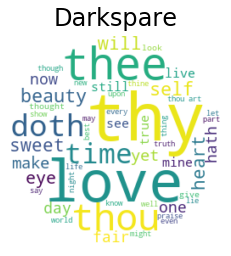

In [14]:
#visualize

fp = r'C:\\Users\\happy\\Desktop\\project 3\\Official_Release\\data\\shakespeare.txt'
text = open(os.path.join(os.getcwd(), fp)).read()
wordcloud = text_to_wordcloud(text, title='Darkspare')

Iteration: 10
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Live habitation absence hath love youth, 
Fill salutation how thee powerful store. 
Sing subject I by love and I me truth, 
You to the seasons as ornament more. 
Hast husband done the the and my is chide, 
Sighs out this me she must you as when boast. 
Few but though like as truest knights that pride, 
Truth of sounds frame rotten widow high ghost. 
Nor times himself her stays that charge you where, 
Stopped be credit were do withal the show. 
Love another's eyes up whether one there, 
Verse my thy stopped fade truant think and grow. 
  The loving minutes or churl removed can, 
  Your and number done shall Your made with man. 



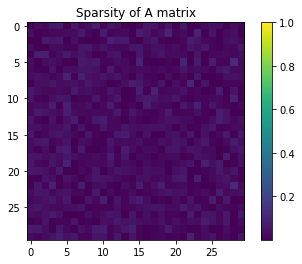

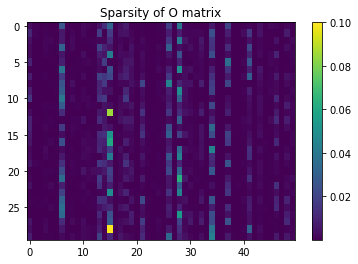

In [18]:
subject, obs_map = make_poem(poem_list, syllable, 30, 10, rythme_dict_encoded)
visualize_sparsities(subject, O_max_cols=50)

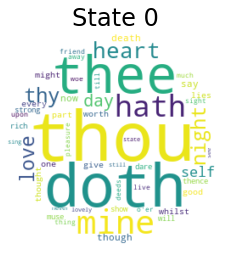

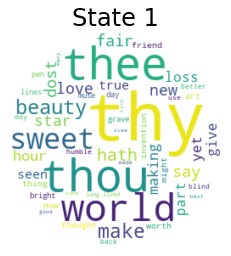

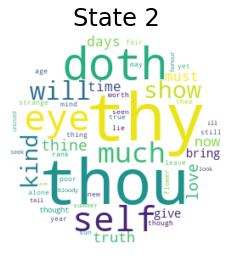

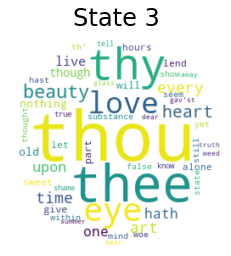

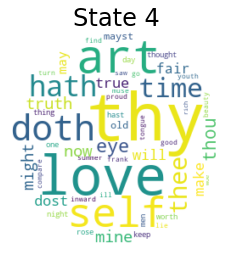

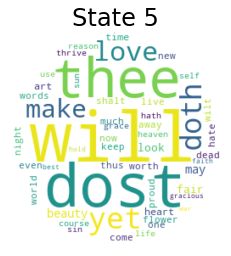

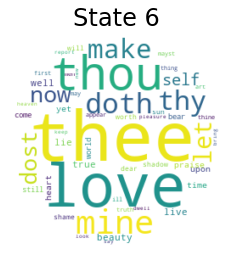

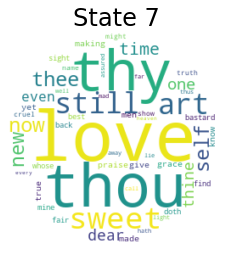

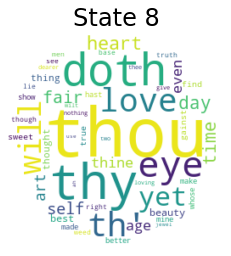

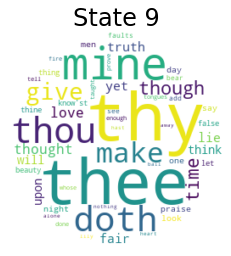

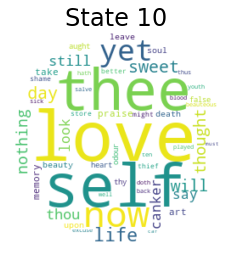

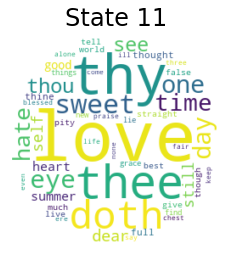

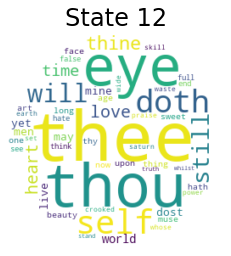

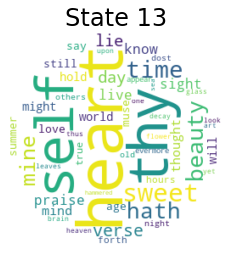

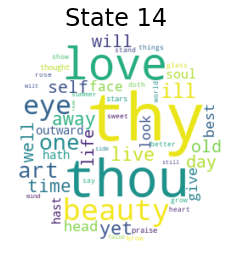

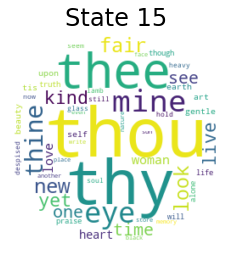

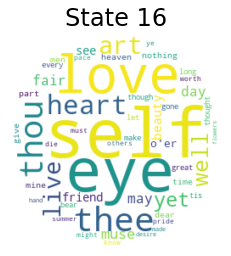

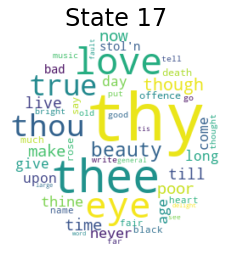

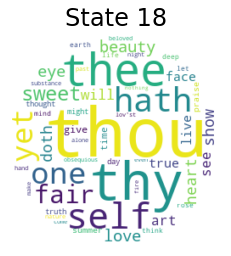

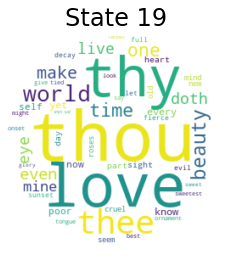

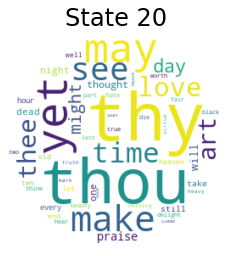

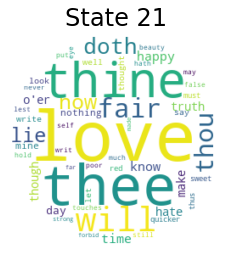

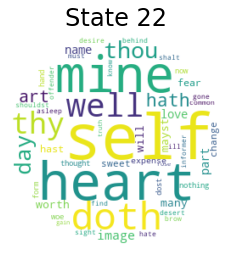

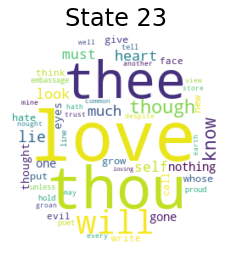

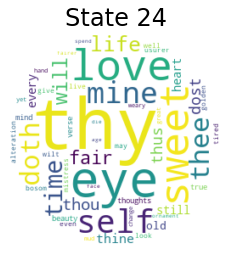

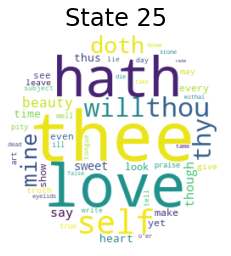

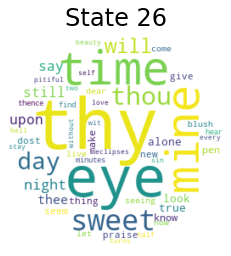

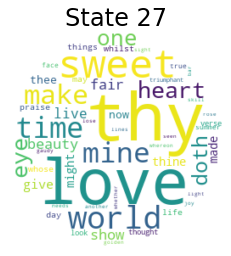

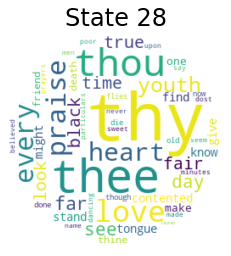

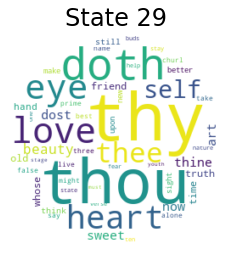

In [19]:
wordclouds = states_to_wordclouds(subject, obs_map)


Animating...


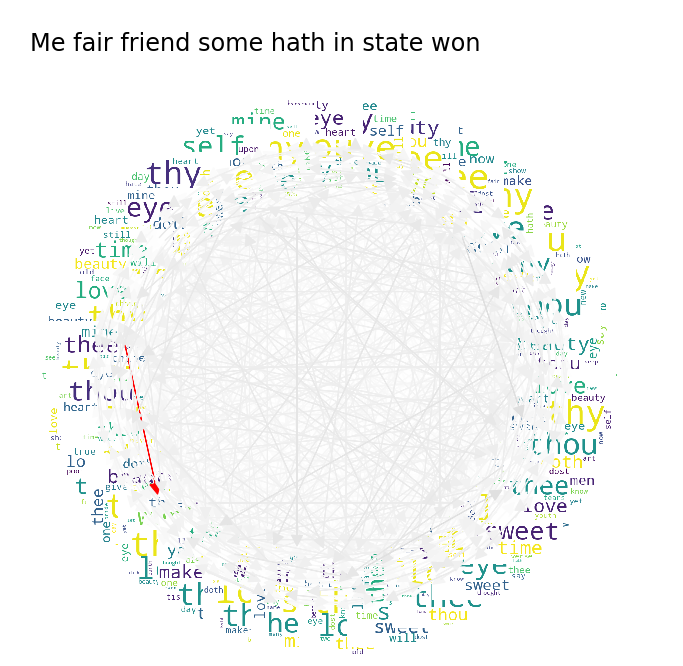

In [20]:
anim = animate_emission(subject, obs_map, M=8)
HTML(anim.to_html5_video())

Iteration: 10
Iteration: 20
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Thee and constant of stewards governs seek, 
Live heart lays receives from and die and loss. 
Damasked loving story till happy cheek, 
That longer thee no o who for thou cross. 
Dial ever and hear if as fast all, 
To love's muse holds be sake and time removed. 
Not excellent age's receivest call, 
The use to impiety beloved. 
My thou crown love love th' sleep self heart much pain, 
Hate and interest th' believe add my one new. 
Ragged lasting body's thy in five gain, 
Than doth like oppression that my and you. 
  So sweet and sweet husband upon to thine, 
  The are and nor might mistress heals thou shine. 



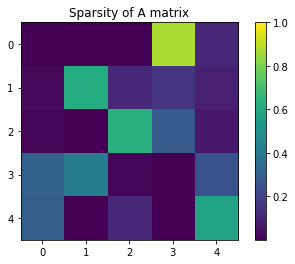

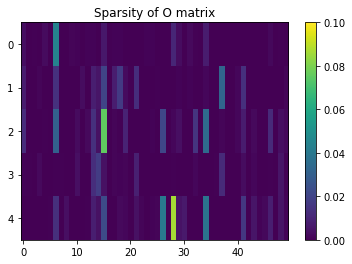

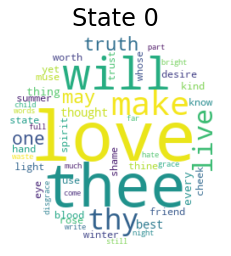

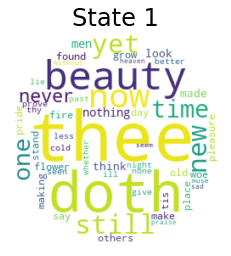

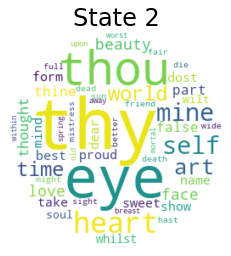

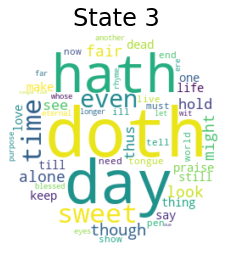

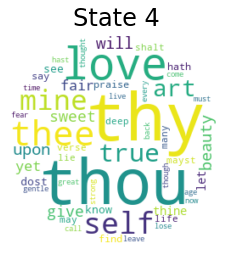

In [24]:
subject, obs_map = make_poem(poem_list, syllable, 5, 20, rythme_dict_encoded)
visualize_sparsities(subject, O_max_cols=50)
wordclouds = states_to_wordclouds(subject, obs_map)

Iteration: 10
Iteration: 20
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
No made love see me believe I leaves I, 
Me the mayst from my in Me witness love. 
Chide thou use that in his book day they be, 
Converted Converted threw her approve. 
Least and put the matter matcheth were no, 
I of my most dost to my eye of I. 
Love-kindling but our best and mine so, 
Need cheater rent my strikes me thee to be. 
O'erlook is asleep art beauty of true, 
Which and love's child and holds my spirit do. 
With image and not pale orient much you, 
And of it is singleness dost brow too. 
  Flesh do leaves th' eyes touched man slave hence none had, 
  You to make to true everywhere thee mad. 



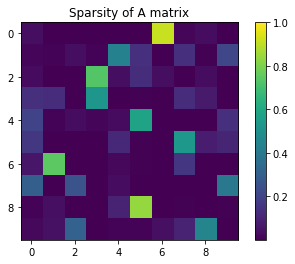

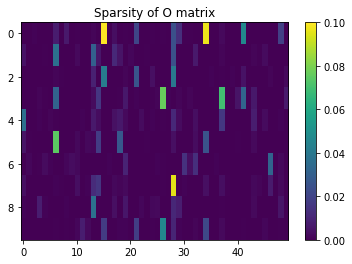

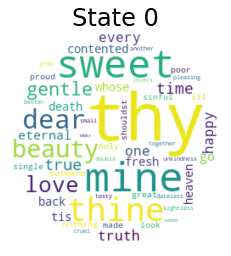

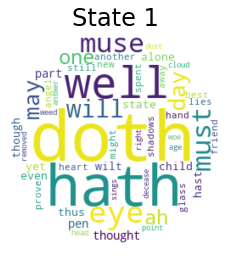

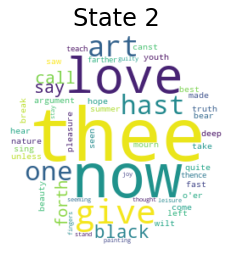

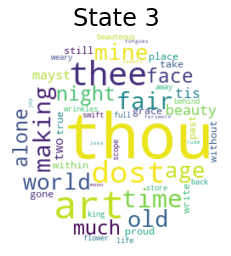

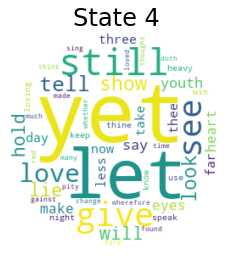

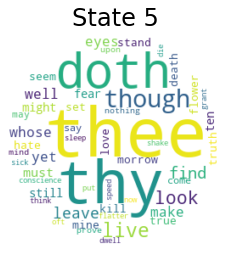

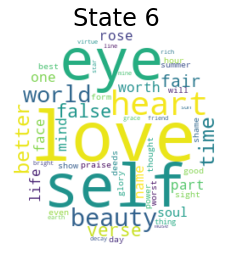

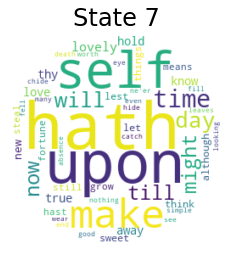

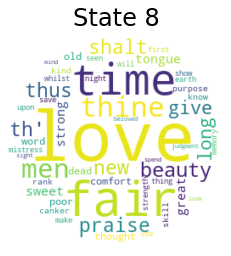

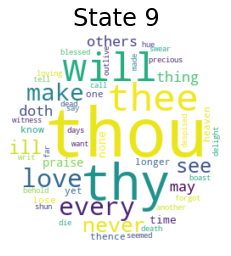

In [25]:
subject, obs_map = make_poem(poem_list, syllable, 10, 20, rythme_dict_encoded)
visualize_sparsities(subject, O_max_cols=50)
wordclouds = states_to_wordclouds(subject, obs_map)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Rosy change such sold this gems even face, 
Thou tired befits shake should so as how. 
Thou in a best poverty of head place, 
Canst not not not what thou do were loved now. 
Thy runs being and that end with hear both, 
Old could still her take more thee and abuse. 
Time since abundance wary being growth, 
Breathers love beauteous hours true thoughts use. 
Wherewith thrive counting over-partial on, 
Minds like mine where thou it are shall in they. 
Veins not the state although as may die gone, 
I a thy wood's can removed thou art say. 
  To in truly strong hath answer art bring, 
  You give constant reason penury sing. 



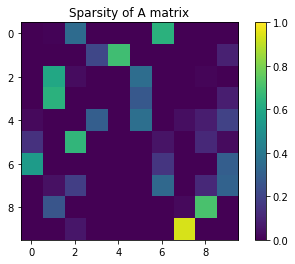

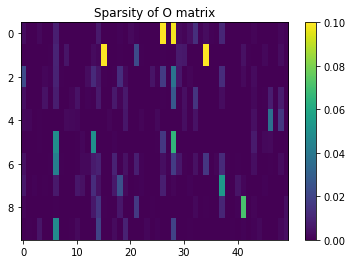

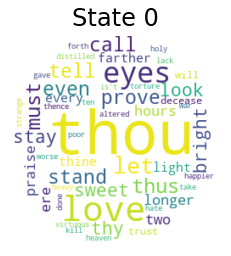

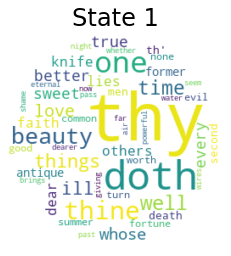

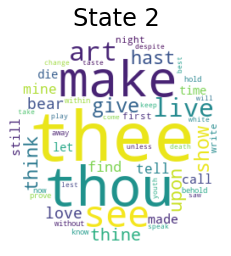

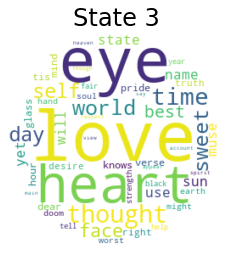

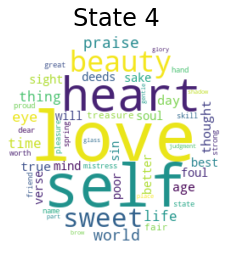

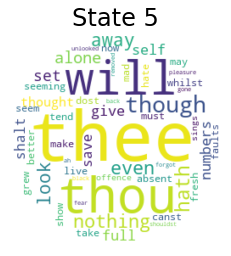

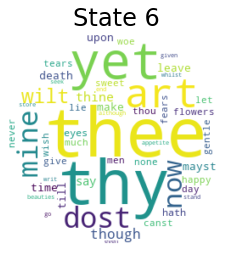

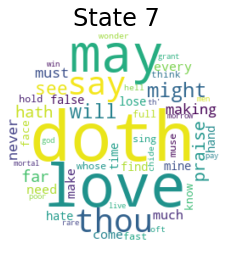

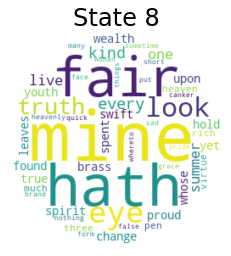

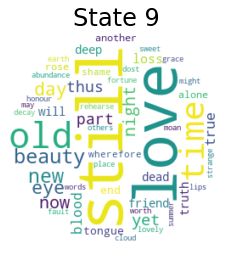

In [28]:
subject, obs_map = make_poem(poem_list, syllable, 10, 100, rythme_dict_encoded)
visualize_sparsities(subject, O_max_cols=50)
wordclouds = states_to_wordclouds(subject, obs_map)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Dark holme ---- Vannnnnn
♂♂♂♀faaaa%$^#$%#%aa&&♂%%%%*&%^R%%♂♂♂
Suffer nor honour mind hues but right heart, 
Gav'st thou thou visage self is yours fair not. 
Lives sight a riper my love thy art art, 
Majesty which thee it plague might forgot. 
Thee worth of incertainty a enlarged, 
Gait the tenth in both with can beauty love. 
Love's I then are horse crowned change my charged, 
And cease face And why I live you And prove. 
Thou female damasked our that rich art, 
Wherein beauty's mine not now excuse me. 
Both then so niggard gone thou to so heart, 
Hand would that weep thus behold the hath thee. 
  Self assailed and you sick thoughts have mind most, 
  Is fuel a in three-fold contain most lost. 



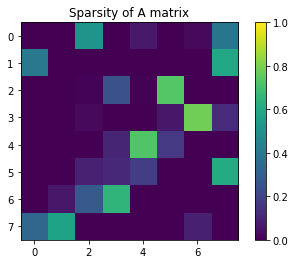

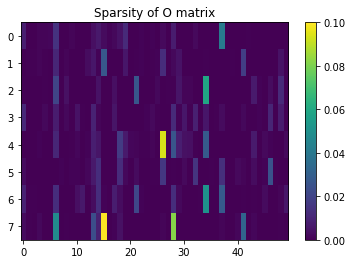

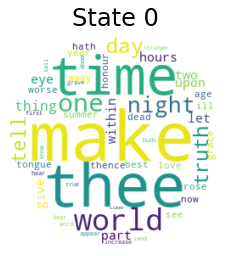

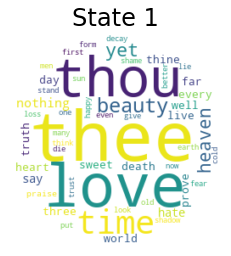

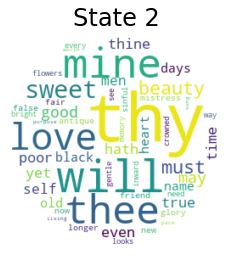

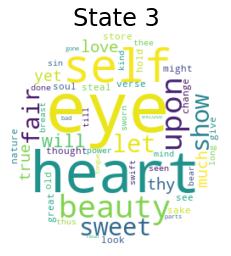

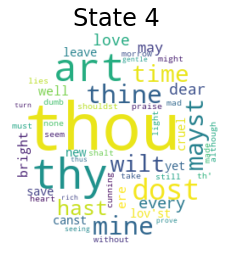

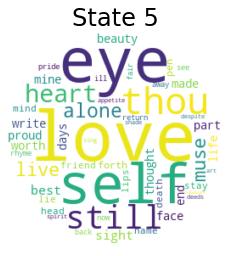

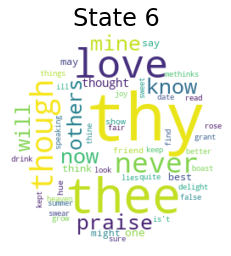

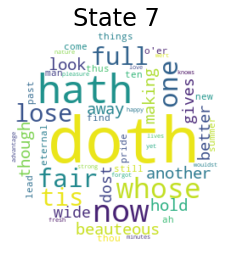

In [29]:
subject, obs_map = make_poem(poem_list, syllable, 8, 50, rythme_dict_encoded)
visualize_sparsities(subject, O_max_cols=50)
wordclouds = states_to_wordclouds(subject, obs_map)

In [37]:
a= 'sfffa\nsdslosbasfas\n'
count = len(re.findall("\n", a)) 
fugma = 'shall i compare thee to a summer’s day t'
len(fugma)

40

In [38]:
len('\n')

1